Inspired/based on https://github.com/rayidghani/magicloops and https://github.com/dssg/MLforPublicPolicy/blob/master/labs/2019/lab6_feature_generation_sol.ipynb

In [3]:
import pipeline_evictions as pipeline
import ml_loop_evictions as loop

import importlib
import datetime
import pandas as pd
import numpy as np

# Read data

In [4]:
importlib.reload(pipeline)

datafile = "data/tracts.csv"

#Read data, parsing year column to date type
data = pd.read_csv(datafile, parse_dates=['year'])

# Basic Cleaning

In [5]:
# Delete rows that do not have eviction-rate. We do not want to impute this value

data.dropna(subset=['eviction-rate'], inplace=True)
data['eviction-rate'].isnull().values.any()
data.reset_index(inplace=True, drop=True)

# Create outcome label

In [6]:
def get_eviction_rate(df, year,geoid):
    
  data_to_return = df.loc[(df['year'] == year) & (df['GEOID'] == geoid)]
  
  if(data_to_return.empty):
    return 0
  
  return data_to_return['eviction-rate'].iloc[0]

In [7]:
importlib.reload(pipeline)

from dateutil.relativedelta import relativedelta

#Obtain eviction-rate cutoff for the top 10%, for each year
cutoff_10_percent={}
for year in range(2000,2017):
    year = pd.Timestamp(year,1,1)
    cutoff_10_percent[year]=data.loc[data['year'] == year]['eviction-rate'].quantile(.9)
    
top_10_eviction_rate_in_any_next_3_years_column = np.zeros(len(data))
print(top_10_eviction_rate_in_any_next_3_years_column.shape)


for index, row in data.iterrows():
  
  #Because the outcome will come from eviction-rate in next 3 years and we have data till 2016,
  #features data bust be from 2013 or before
  
  if(row['year']<=pd.Timestamp(2013,1,1)):    
    
    found_year_where_eviction_was_in_top_10_percent=0
    
    #Get eviction for the next 3 years
    for i in range(1,4):
      date_in_i_years = row['year'] + relativedelta(years=i)
      eviction_rate_in_i_years = get_eviction_rate(data, date_in_i_years,row['GEOID'])
    
      top_10_eviction_rate_in_i_years = 1 if eviction_rate_in_i_years>= cutoff_10_percent[date_in_i_years] else 0
      

      
      #If we found one year that meets requirement, we are done with looping
      if(top_10_eviction_rate_in_i_years==1):
        found_year_where_eviction_was_in_top_10_percent=1
        break

    top_10_eviction_rate_in_any_next_3_years_column[index]=found_year_where_eviction_was_in_top_10_percent

data['top_10_percent_in_any_next_3_years'] = top_10_eviction_rate_in_any_next_3_years_column

label ='top_10_percent_in_any_next_3_years'




(27889,)


In [8]:
#Debugging. In case we want to add 1 column for each future year with top 10%

      # eviction_rate_in_1_year = np.zeros(len(data))
# cutoff_in_1_year = np.zeros(len(data))

      
#       if(top_10_eviction_rate_in_i_years==1):
#         print(row['GEOID'])
#         print(row['year'])
#         print(date_in_i_years)
#         print(eviction_rate_in_i_years)
#         print(cutoff_10_percent[date_in_i_years])
#         print(top_10_eviction_rate_in_i_years)     

#       if(i==1):
#         eviction_rate_in_1_year[index]=eviction_rate_in_i_years
#         cutoff_in_1_year[index]=cutoff_10_percent[date_in_i_years]

# data['eviction_rate_in_1_year']='eviction_rate_in_1_year'
# data['cutoff_in_1_year']='eviction_rate_in_1_year'      
    

# Create temporal train and test sets

In [9]:
importlib.reload(pipeline)

#Create sets of train and test data, based on different split thresholds
#The split thresholds corresponds to the starting date of the testing data

#Splits according to https://docs.google.com/spreadsheets/d/1ipqsgThz7hdXXyyNpTuqa4J1inc088lop7lhFsAQ_r0/edit#gid=0
split_thresholds = [pd.Timestamp(i,1,1) for i in range (2004, 2014)]

#Indicating which is the column to be used for splitting training and test daata
date_column='year'

#Amount of data used for test set
test_window = relativedelta(years=4)

#Gap needed between training and test set
prediction_horizon = relativedelta(years=3)

#Generate train and test sets
train_test_sets= pipeline.create_temp_validation_train_and_testing_sets(
  data,
  date_column,
  label,
  split_thresholds,
  test_window,
  prediction_horizon)

In [10]:
for c in train_test_sets[5]['x_train'].columns:
  print(c)

GEOID
year
name
parent-location
population
poverty-rate
renter-occupied-households
pct-renter-occupied
median-gross-rent
median-household-income
median-property-value
rent-burden
pct-white
pct-af-am
pct-hispanic
pct-am-ind
pct-asian
pct-nh-pi
pct-multiple
pct-other
eviction-filings
evictions
eviction-rate
eviction-filing-rate
low-flag
imputed
subbed


# Imputation

In [11]:
importlib.reload(pipeline)

#Impute data on continuous columns for each training and test set

#--->PENDING
#In the meantime, imputing all float columns with mean
  
float_columns = [column for column in data.columns if data[column].dtype=='float']

#Do not consider GEOID column nor top_10_percent_in_any_next_3_years
float_columns.remove('name')
float_columns.remove('top_10_percent_in_any_next_3_years')


for train_test_set in train_test_sets:
  train_data = train_test_set['x_train']
  test_data = train_test_set['x_test']

  #fill na values with mean
  pipeline.impute_data(train_data, float_columns)
  pipeline.impute_data(test_data, float_columns)


# Create features

In [12]:
import feature_generation as fg

importlib.reload(pipeline)
importlib.reload(fg)

#We will have to generate features independently for each different train/test set
for train_test_set in train_test_sets:

  train_features = fg.create_features(train_test_set['x_train'])
  test_features = fg.create_features(train_test_set['x_test']) 
  
  #Alternative for just working with default features
  #train_features, test_features = pipeline.create_features(train_test_set)
  
  #Replace raw data in train_test_set with features generated
  train_test_set['x_train'] = train_features
  train_test_set['x_test'] = test_features

# Build Clasifiers and parameters generation

In [13]:
importlib.reload(pipeline)

#We define the specific models we want to run
models_to_run=['LR','DT','RF','KNN','NB','BA','AB','GB','ET']#,SVM'

#Get all posible models and their different sets of parameters
models, parameters_grid = pipeline.get_models_and_parameters()

# Loop over models and different training/test sets

In [14]:
# print(len(train_test_sets[0]['x_test']))
# print(len(train_test_sets[0]['y_test']))
train_test_sets[0]['y_test'].isnull().any()
# df.isnull().values.any()

# for column in train_test_sets[5]['x_test'].columns:
#   print(column)
  
np.sum(len(train_test_sets[5]['x_test']))

1300

In [15]:
importlib.reload(pipeline)
importlib.reload(loop)

import warnings

warnings.filterwarnings('ignore')

results = loop.iterate_over_models_and_training_test_sets(models_to_run, models, parameters_grid, train_test_sets)
results

2019-06-12 07:57:27.536716: Running LR with params: {'C': 0.001, 'penalty': 'l1'} on train/test set 2004-01-01 00:00:00
2019-06-12 07:57:27.996724: Running LR with params: {'C': 0.001, 'penalty': 'l2'} on train/test set 2004-01-01 00:00:00
2019-06-12 07:57:28.413423: Running LR with params: {'C': 0.1, 'penalty': 'l1'} on train/test set 2004-01-01 00:00:00
2019-06-12 07:57:29.898325: Running LR with params: {'C': 0.1, 'penalty': 'l2'} on train/test set 2004-01-01 00:00:00
2019-06-12 07:57:30.278459: Running LR with params: {'C': 1, 'penalty': 'l1'} on train/test set 2004-01-01 00:00:00
2019-06-12 07:57:31.418492: Running LR with params: {'C': 1, 'penalty': 'l2'} on train/test set 2004-01-01 00:00:00
2019-06-12 07:57:31.814619: Running LR with params: {'C': 10, 'penalty': 'l1'} on train/test set 2004-01-01 00:00:00
2019-06-12 07:57:46.464250: Running LR with params: {'C': 10, 'penalty': 'l2'} on train/test set 2004-01-01 00:00:00
2019-06-12 07:57:46.841994: Running DT with params: {'crit

2019-06-12 07:58:22.496319: Running RF with params: {'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2004-01-01 00:00:00
2019-06-12 07:58:22.998748: Running RF with params: {'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 1000, 'n_jobs': -1} on train/test set 2004-01-01 00:00:00
2019-06-12 07:58:25.523544: Running KNN with params: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'} on train/test set 2004-01-01 00:00:00
2019-06-12 07:58:25.815617: Running KNN with params: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'} on train/test set 2004-01-01 00:00:00
2019-06-12 07:58:26.098925: Running KNN with params: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'} on train/test set 2004-01-01 00:00:00
2019-06-12 07:58:26.391583: Running KNN with params: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'} on train/test set 2004-01-01 00:00:00

2019-06-12 07:59:58.699532: Running LR with params: {'C': 10, 'penalty': 'l2'} on train/test set 2005-01-01 00:00:00
2019-06-12 07:59:59.166517: Running DT with params: {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2} on train/test set 2005-01-01 00:00:00
2019-06-12 07:59:59.654427: Running DT with params: {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 5} on train/test set 2005-01-01 00:00:00
2019-06-12 07:59:59.989342: Running DT with params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2} on train/test set 2005-01-01 00:00:00
2019-06-12 08:00:00.307023: Running DT with params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5} on train/test set 2005-01-01 00:00:00
2019-06-12 08:00:00.603298: Running DT with params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2} on train/test set 2005-01-01 00:00:00
2019-06-12 08:00:00.923101: Running DT with params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5} on trai

2019-06-12 08:00:56.179258: Running KNN with params: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'} on train/test set 2005-01-01 00:00:00
2019-06-12 08:00:56.470736: Running KNN with params: {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'} on train/test set 2005-01-01 00:00:00
2019-06-12 08:00:56.781706: Running KNN with params: {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'} on train/test set 2005-01-01 00:00:00
2019-06-12 08:00:57.077527: Running KNN with params: {'algorithm': 'auto', 'n_neighbors': 50, 'weights': 'uniform'} on train/test set 2005-01-01 00:00:00
2019-06-12 08:00:57.457480: Running KNN with params: {'algorithm': 'auto', 'n_neighbors': 50, 'weights': 'distance'} on train/test set 2005-01-01 00:00:00
2019-06-12 08:00:57.885628: Running KNN with params: {'algorithm': 'auto', 'n_neighbors': 100, 'weights': 'uniform'} on train/test set 2005-01-01 00:00:00
2019-06-12 08:00:58.342874: Running KNN with params: {'algorithm': 'auto'

2019-06-12 08:02:48.291064: Running DT with params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5} on train/test set 2006-01-01 00:00:00
2019-06-12 08:02:48.610112: Running DT with params: {'criterion': 'gini', 'max_depth': 50, 'min_samples_split': 2} on train/test set 2006-01-01 00:00:00
2019-06-12 08:02:48.945173: Running DT with params: {'criterion': 'gini', 'max_depth': 50, 'min_samples_split': 5} on train/test set 2006-01-01 00:00:00
2019-06-12 08:02:49.267638: Running DT with params: {'criterion': 'gini', 'max_depth': 100, 'min_samples_split': 2} on train/test set 2006-01-01 00:00:00
2019-06-12 08:02:49.600960: Running DT with params: {'criterion': 'gini', 'max_depth': 100, 'min_samples_split': 5} on train/test set 2006-01-01 00:00:00
2019-06-12 08:02:49.932597: Running DT with params: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 2} on train/test set 2006-01-01 00:00:00
2019-06-12 08:02:50.206273: Running DT with params: {'criterion': 'entropy', '

2019-06-12 08:03:46.622186: Running KNN with params: {'algorithm': 'auto', 'n_neighbors': 100, 'weights': 'distance'} on train/test set 2006-01-01 00:00:00
2019-06-12 08:03:47.131810: Running KNN with params: {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'uniform'} on train/test set 2006-01-01 00:00:00
2019-06-12 08:03:47.532071: Running KNN with params: {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'distance'} on train/test set 2006-01-01 00:00:00
2019-06-12 08:03:47.937102: Running KNN with params: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'uniform'} on train/test set 2006-01-01 00:00:00
2019-06-12 08:03:48.351010: Running KNN with params: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'} on train/test set 2006-01-01 00:00:00
2019-06-12 08:03:48.754446: Running KNN with params: {'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'uniform'} on train/test set 2006-01-01 00:00:00
2019-06-12 08:03:49.187748: Running KNN with params

2019-06-12 08:06:54.347056: Running DT with params: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 5} on train/test set 2007-01-01 00:00:00
2019-06-12 08:06:54.641247: Running DT with params: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2} on train/test set 2007-01-01 00:00:00
2019-06-12 08:06:54.982122: Running DT with params: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5} on train/test set 2007-01-01 00:00:00
2019-06-12 08:06:55.314932: Running DT with params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2} on train/test set 2007-01-01 00:00:00
2019-06-12 08:06:55.684458: Running DT with params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5} on train/test set 2007-01-01 00:00:00
2019-06-12 08:06:56.055590: Running DT with params: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_split': 2} on train/test set 2007-01-01 00:00:00
2019-06-12 08:06:56.437622: Running DT with params: {'criterion': '

2019-06-12 08:08:05.247924: Running KNN with params: {'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'distance'} on train/test set 2007-01-01 00:00:00
2019-06-12 08:08:05.822764: Running KNN with params: {'algorithm': 'ball_tree', 'n_neighbors': 50, 'weights': 'uniform'} on train/test set 2007-01-01 00:00:00
2019-06-12 08:08:06.568941: Running KNN with params: {'algorithm': 'ball_tree', 'n_neighbors': 50, 'weights': 'distance'} on train/test set 2007-01-01 00:00:00
2019-06-12 08:08:07.321446: Running KNN with params: {'algorithm': 'ball_tree', 'n_neighbors': 100, 'weights': 'uniform'} on train/test set 2007-01-01 00:00:00
2019-06-12 08:08:08.134949: Running KNN with params: {'algorithm': 'ball_tree', 'n_neighbors': 100, 'weights': 'distance'} on train/test set 2007-01-01 00:00:00
2019-06-12 08:08:08.944483: Running NB with params: {} on train/test set 2007-01-01 00:00:00
2019-06-12 08:08:09.223887: Running BA with params: {'n_estimators': 10} on train/test set 2007-01-01 00:00

2019-06-12 08:10:59.629907: Running DT with params: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_split': 5} on train/test set 2008-01-01 00:00:00
2019-06-12 08:11:00.033094: Running DT with params: {'criterion': 'entropy', 'max_depth': 100, 'min_samples_split': 2} on train/test set 2008-01-01 00:00:00
2019-06-12 08:11:00.453225: Running DT with params: {'criterion': 'entropy', 'max_depth': 100, 'min_samples_split': 5} on train/test set 2008-01-01 00:00:00
2019-06-12 08:11:00.856599: Running RF with params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2008-01-01 00:00:00
2019-06-12 08:11:01.616826: Running RF with params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 1000, 'n_jobs': -1} on train/test set 2008-01-01 00:00:00
2019-06-12 08:11:05.391118: Running RF with params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': 

2019-06-12 08:12:21.629425: Running NB with params: {} on train/test set 2008-01-01 00:00:00
2019-06-12 08:12:21.904828: Running BA with params: {'n_estimators': 10} on train/test set 2008-01-01 00:00:00
2019-06-12 08:12:23.701358: Running BA with params: {'n_estimators': 100} on train/test set 2008-01-01 00:00:00
2019-06-12 08:12:38.635124: Running AB with params: {'algorithm': 'SAMME', 'n_estimators': 10} on train/test set 2008-01-01 00:00:00
2019-06-12 08:12:39.051056: Running AB with params: {'algorithm': 'SAMME', 'n_estimators': 100} on train/test set 2008-01-01 00:00:00
2019-06-12 08:12:41.086487: Running AB with params: {'algorithm': 'SAMME.R', 'n_estimators': 10} on train/test set 2008-01-01 00:00:00
2019-06-12 08:12:41.511205: Running AB with params: {'algorithm': 'SAMME.R', 'n_estimators': 100} on train/test set 2008-01-01 00:00:00
2019-06-12 08:12:43.597593: Running GB with params: {'learning_rate': 0.001, 'n_estimators': 10, 'subsample': 0.1} on train/test set 2008-01-01 00

2019-06-12 08:16:22.653695: Running RF with params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2009-01-01 00:00:00
2019-06-12 08:16:23.501414: Running RF with params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 1000, 'n_jobs': -1} on train/test set 2009-01-01 00:00:00
2019-06-12 08:16:28.551446: Running RF with params: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2009-01-01 00:00:00
2019-06-12 08:16:29.527074: Running RF with params: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 1000, 'n_jobs': -1} on train/test set 2009-01-01 00:00:00
2019-06-12 08:16:33.880710: Running RF with params: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2009-01-01 00:00:00
2019-06-12 08:16:35.159346: Running RF with p

2019-06-12 08:18:59.978646: Running GB with params: {'learning_rate': 0.001, 'n_estimators': 10, 'subsample': 0.1} on train/test set 2009-01-01 00:00:00
2019-06-12 08:19:00.892779: Running GB with params: {'learning_rate': 0.001, 'n_estimators': 10, 'subsample': 1.0} on train/test set 2009-01-01 00:00:00
2019-06-12 08:19:02.524329: Running GB with params: {'learning_rate': 0.001, 'n_estimators': 100, 'subsample': 0.1} on train/test set 2009-01-01 00:00:00
2019-06-12 08:19:05.664000: Running GB with params: {'learning_rate': 0.001, 'n_estimators': 100, 'subsample': 1.0} on train/test set 2009-01-01 00:00:00
2019-06-12 08:19:09.396831: Running GB with params: {'learning_rate': 0.1, 'n_estimators': 10, 'subsample': 0.1} on train/test set 2009-01-01 00:00:00
2019-06-12 08:19:09.852957: Running GB with params: {'learning_rate': 0.1, 'n_estimators': 10, 'subsample': 1.0} on train/test set 2009-01-01 00:00:00
2019-06-12 08:19:10.559401: Running GB with params: {'learning_rate': 0.1, 'n_estima

2019-06-12 08:23:02.846502: Running RF with params: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2010-01-01 00:00:00
2019-06-12 08:23:03.591666: Running RF with params: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 1000, 'n_jobs': -1} on train/test set 2010-01-01 00:00:00
2019-06-12 08:23:07.399579: Running RF with params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2010-01-01 00:00:00
2019-06-12 08:23:08.933452: Running RF with params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 1000, 'n_jobs': -1} on train/test set 2010-01-01 00:00:00
2019-06-12 08:23:19.348929: Running RF with params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2010-01-01 00:00:00
2019-06-12 08:23:20.837858: Running RF wit

2019-06-12 08:25:26.642013: Running GB with params: {'learning_rate': 0.1, 'n_estimators': 10, 'subsample': 1.0} on train/test set 2010-01-01 00:00:00
2019-06-12 08:25:27.234239: Running GB with params: {'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.1} on train/test set 2010-01-01 00:00:00
2019-06-12 08:25:29.110605: Running GB with params: {'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 1.0} on train/test set 2010-01-01 00:00:00
2019-06-12 08:25:32.243633: Running ET with params: {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 100} on train/test set 2010-01-01 00:00:00
2019-06-12 08:25:32.720357: Running ET with params: {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 1000} on train/test set 2010-01-01 00:00:00
2019-06-12 08:25:34.695303: Running ET with params: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100} on train/test set 2010-01-01 00:00:00
2019-06-12 08:25:35.322089: Running ET with params: {'criterion': 'gini', 'max_depth': 5, 'n_esti

2019-06-12 08:29:49.017863: Running RF with params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2011-01-01 00:00:00
2019-06-12 08:29:50.500348: Running RF with params: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 1000, 'n_jobs': -1} on train/test set 2011-01-01 00:00:00
2019-06-12 08:30:01.299882: Running RF with params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2011-01-01 00:00:00
2019-06-12 08:30:02.453482: Running RF with params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 1000, 'n_jobs': -1} on train/test set 2011-01-01 00:00:00
2019-06-12 08:30:10.444072: Running RF with params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2011-01-01 00:00:00
2019-06-12 08:30:11.525518: Running RF w

2019-06-12 08:32:18.328557: Running ET with params: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100} on train/test set 2011-01-01 00:00:00
2019-06-12 08:32:18.938172: Running ET with params: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 1000} on train/test set 2011-01-01 00:00:00
2019-06-12 08:32:21.894271: Running ET with params: {'criterion': 'gini', 'max_depth': 50, 'n_estimators': 100} on train/test set 2011-01-01 00:00:00
2019-06-12 08:32:22.960543: Running ET with params: {'criterion': 'gini', 'max_depth': 50, 'n_estimators': 1000} on train/test set 2011-01-01 00:00:00
2019-06-12 08:32:30.272559: Running ET with params: {'criterion': 'entropy', 'max_depth': 2, 'n_estimators': 100} on train/test set 2011-01-01 00:00:00
2019-06-12 08:32:30.739912: Running ET with params: {'criterion': 'entropy', 'max_depth': 2, 'n_estimators': 1000} on train/test set 2011-01-01 00:00:00
2019-06-12 08:32:32.710806: Running ET with params: {'criterion': 'entropy', 'max_depth': 5, 'n

2019-06-12 08:37:42.620913: Running RF with params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2012-01-01 00:00:00
2019-06-12 08:37:43.796207: Running RF with params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 1000, 'n_jobs': -1} on train/test set 2012-01-01 00:00:00
2019-06-12 08:37:52.322876: Running RF with params: {'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2012-01-01 00:00:00
2019-06-12 08:37:53.858795: Running RF with params: {'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 1000, 'n_jobs': -1} on train/test set 2012-01-01 00:00:00
2019-06-12 08:38:06.385236: Running RF with params: {'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2012-01-01 00:00:00
2019-06-12 08:38:07.891467: Running R

2019-06-12 08:40:26.411177: Running ET with params: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 100} on train/test set 2012-01-01 00:00:00
2019-06-12 08:40:27.007782: Running ET with params: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 1000} on train/test set 2012-01-01 00:00:00
2019-06-12 08:40:30.179264: Running ET with params: {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 100} on train/test set 2012-01-01 00:00:00
2019-06-12 08:40:31.350755: Running ET with params: {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 1000} on train/test set 2012-01-01 00:00:00
2019-06-12 08:40:39.139267: Running LR with params: {'C': 0.001, 'penalty': 'l1'} on train/test set 2013-01-01 00:00:00
2019-06-12 08:40:43.928224: Running LR with params: {'C': 0.001, 'penalty': 'l2'} on train/test set 2013-01-01 00:00:00
2019-06-12 08:40:45.151653: Running LR with params: {'C': 0.1, 'penalty': 'l1'} on train/test set 2013-01-01 00:00:00
2019-06-12 08:42:00.789942: Ru

2019-06-12 08:47:58.067695: Running RF with params: {'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 1000, 'n_jobs': -1} on train/test set 2013-01-01 00:00:00
2019-06-12 08:48:10.934061: Running RF with params: {'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2013-01-01 00:00:00
2019-06-12 08:48:12.593246: Running RF with params: {'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 1000, 'n_jobs': -1} on train/test set 2013-01-01 00:00:00
2019-06-12 08:48:22.998246: Running RF with params: {'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2013-01-01 00:00:00
2019-06-12 08:48:24.171878: Running RF with params: {'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 1000, 'n_jobs': -1} on train/test set 2013-01-01 00:00:00
2019-06-12 08:48:33.303346: Runnin

,model_name,model,parameters,test_set_start_date,baseline,p_at_1,r_at_1,f1_at_1,p_at_2,r_at_2,...,p_at_20,r_at_20,f1_at_20,p_at_30,r_at_30,f1_at_30,p_at_50,r_at_50,f1_at_50,auc-roc
0,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 0.001, 'penalty': 'l1'}",2004-01-01,0.139671,1.000000,0.068441,0.128114,1.000000,0.140684,...,0.574468,0.821293,0.676056,0.423759,0.908745,0.577993,0.274176,0.980989,0.428571,0.940694
1,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 0.001, 'penalty': 'l2'}",2004-01-01,0.139671,1.000000,0.068441,0.128114,0.972973,0.136882,...,0.593085,0.847909,0.697966,0.439716,0.942966,0.599758,0.277365,0.992395,0.433555,0.955272
2,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 0.1, 'penalty': 'l1'}",2004-01-01,0.139671,0.777778,0.053232,0.099644,0.783784,0.110266,...,0.555851,0.794677,0.654147,0.425532,0.912548,0.580411,0.272051,0.973384,0.425249,0.927996
3,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 0.1, 'penalty': 'l2'}",2004-01-01,0.139671,1.000000,0.068441,0.128114,0.972973,0.136882,...,0.590426,0.844106,0.694836,0.439716,0.942966,0.599758,0.277365,0.992395,0.433555,0.953185
4,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 1, 'penalty': 'l1'}",2004-01-01,0.139671,0.833333,0.057034,0.106762,0.567568,0.079848,...,0.563830,0.806084,0.663537,0.423759,0.908745,0.577993,0.269926,0.965779,0.421927,0.918296
5,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 1, 'penalty': 'l2'}",2004-01-01,0.139671,1.000000,0.068441,0.128114,0.972973,0.136882,...,0.614362,0.878327,0.723005,0.439716,0.942966,0.599758,0.276302,0.988593,0.431894,0.955891
6,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 10, 'penalty': 'l1'}",2004-01-01,0.139671,0.833333,0.057034,0.106762,0.513514,0.072243,...,0.555851,0.794677,0.654147,0.425532,0.912548,0.580411,0.268863,0.961977,0.420266,0.912693
7,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 10, 'penalty': 'l2'}",2004-01-01,0.139671,1.000000,0.068441,0.128114,1.000000,0.140684,...,0.601064,0.859316,0.707355,0.443262,0.950570,0.604595,0.277365,0.992395,0.433555,0.958478
8,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 2, 'min_sam...",2004-01-01,0.139671,1.000000,0.068441,0.128114,1.000000,0.140684,...,0.523936,0.749049,0.616588,0.349291,0.749049,0.476421,0.279490,1.000000,0.436877,0.912381
9,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 2, 'min_sam...",2004-01-01,0.139671,1.000000,0.068441,0.128114,1.000000,0.140684,...,0.523936,0.749049,0.616588,0.349291,0.749049,0.476421,0.279490,1.000000,0.436877,0.912381


<Figure size 432x288 with 0 Axes>

# Observe best models for each train/test set, for different metrics

In [16]:
results

,model_name,model,parameters,test_set_start_date,baseline,p_at_1,r_at_1,f1_at_1,p_at_2,r_at_2,...,p_at_20,r_at_20,f1_at_20,p_at_30,r_at_30,f1_at_30,p_at_50,r_at_50,f1_at_50,auc-roc
0,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 0.001, 'penalty': 'l1'}",2004-01-01,0.139671,1.000000,0.068441,0.128114,1.000000,0.140684,...,0.574468,0.821293,0.676056,0.423759,0.908745,0.577993,0.274176,0.980989,0.428571,0.940694
1,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 0.001, 'penalty': 'l2'}",2004-01-01,0.139671,1.000000,0.068441,0.128114,0.972973,0.136882,...,0.593085,0.847909,0.697966,0.439716,0.942966,0.599758,0.277365,0.992395,0.433555,0.955272
2,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 0.1, 'penalty': 'l1'}",2004-01-01,0.139671,0.777778,0.053232,0.099644,0.783784,0.110266,...,0.555851,0.794677,0.654147,0.425532,0.912548,0.580411,0.272051,0.973384,0.425249,0.927996
3,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 0.1, 'penalty': 'l2'}",2004-01-01,0.139671,1.000000,0.068441,0.128114,0.972973,0.136882,...,0.590426,0.844106,0.694836,0.439716,0.942966,0.599758,0.277365,0.992395,0.433555,0.953185
4,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 1, 'penalty': 'l1'}",2004-01-01,0.139671,0.833333,0.057034,0.106762,0.567568,0.079848,...,0.563830,0.806084,0.663537,0.423759,0.908745,0.577993,0.269926,0.965779,0.421927,0.918296
5,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 1, 'penalty': 'l2'}",2004-01-01,0.139671,1.000000,0.068441,0.128114,0.972973,0.136882,...,0.614362,0.878327,0.723005,0.439716,0.942966,0.599758,0.276302,0.988593,0.431894,0.955891
6,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 10, 'penalty': 'l1'}",2004-01-01,0.139671,0.833333,0.057034,0.106762,0.513514,0.072243,...,0.555851,0.794677,0.654147,0.425532,0.912548,0.580411,0.268863,0.961977,0.420266,0.912693
7,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 10, 'penalty': 'l2'}",2004-01-01,0.139671,1.000000,0.068441,0.128114,1.000000,0.140684,...,0.601064,0.859316,0.707355,0.443262,0.950570,0.604595,0.277365,0.992395,0.433555,0.958478
8,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 2, 'min_sam...",2004-01-01,0.139671,1.000000,0.068441,0.128114,1.000000,0.140684,...,0.523936,0.749049,0.616588,0.349291,0.749049,0.476421,0.279490,1.000000,0.436877,0.912381
9,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 2, 'min_sam...",2004-01-01,0.139671,1.000000,0.068441,0.128114,1.000000,0.140684,...,0.523936,0.749049,0.616588,0.349291,0.749049,0.476421,0.279490,1.000000,0.436877,0.912381


In [17]:
importlib.reload(pipeline)

#Lets obtain the best model for each train/test set, for each metric
metrics_to_display = ['p_at_5','p_at_10', 'auc-roc']

best_models_per_metric = {}

for metric in metrics_to_display:
    #indices of rows that have max value in specific metric for each train/test set
    idx = results.groupby(['test_set_start_date'])[metric].transform(max) == results[metric]

    #save table of best models at the specific metric
    best_models_per_metric[metric] = results[idx]

### Best models for Precision at 5%

In [18]:
best_models_per_metric['p_at_5'].iloc[:, [0,2,3,4,11,12,13]]

,model_name,parameters,test_set_start_date,baseline,p_at_5,r_at_5,f1_at_5
7,LR,"{'C': 10, 'penalty': 'l2'}",2004-01-01,0.139671,0.968085,0.346008,0.509804
128,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2005-01-01,0.140202,0.968085,0.344697,0.508380
130,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2005-01-01,0.140202,0.968085,0.344697,0.508380
134,RF,"{'max_depth': 5, 'max_features': 'log2', 'min_...",2005-01-01,0.140202,0.968085,0.344697,0.508380
136,RF,"{'max_depth': 50, 'max_features': 'sqrt', 'min...",2005-01-01,0.140202,0.968085,0.344697,0.508380
138,RF,"{'max_depth': 50, 'max_features': 'sqrt', 'min...",2005-01-01,0.140202,0.968085,0.344697,0.508380
142,RF,"{'max_depth': 50, 'max_features': 'log2', 'min...",2005-01-01,0.140202,0.968085,0.344697,0.508380
144,RF,"{'max_depth': 100, 'max_features': 'sqrt', 'mi...",2005-01-01,0.140202,0.968085,0.344697,0.508380
146,RF,"{'max_depth': 100, 'max_features': 'sqrt', 'mi...",2005-01-01,0.140202,0.968085,0.344697,0.508380
150,RF,"{'max_depth': 100, 'max_features': 'log2', 'mi...",2005-01-01,0.140202,0.968085,0.344697,0.508380


### Best models for Precision at 10%

In [19]:
best_models_per_metric['p_at_10'].iloc[:, [0,2,3,4,14,15,16]]

,model_name,parameters,test_set_start_date,baseline,p_at_10,r_at_10,f1_at_10
5,LR,"{'C': 1, 'penalty': 'l2'}",2004-01-01,0.139671,0.872340,0.623574,0.727273
135,RF,"{'max_depth': 50, 'max_features': 'sqrt', 'min...",2005-01-01,0.140202,0.824468,0.587121,0.685841
143,RF,"{'max_depth': 100, 'max_features': 'sqrt', 'mi...",2005-01-01,0.140202,0.824468,0.587121,0.685841
238,RF,"{'max_depth': 50, 'max_features': 'log2', 'min...",2006-01-01,0.111524,0.563830,0.504762,0.532663
246,RF,"{'max_depth': 100, 'max_features': 'log2', 'mi...",2006-01-01,0.111524,0.563830,0.504762,0.532663
378,GB,"{'learning_rate': 0.001, 'n_estimators': 100, ...",2007-01-01,0.154198,0.854962,0.554455,0.672673
433,RF,"{'max_depth': 50, 'max_features': 'sqrt', 'min...",2008-01-01,0.145802,0.801527,0.549738,0.652174
441,RF,"{'max_depth': 100, 'max_features': 'sqrt', 'mi...",2008-01-01,0.145802,0.801527,0.549738,0.652174
576,GB,"{'learning_rate': 0.001, 'n_estimators': 100, ...",2009-01-01,0.146154,0.853846,0.584211,0.693750
595,LR,"{'C': 0.001, 'penalty': 'l2'}",2010-01-01,0.170803,0.941606,0.551282,0.695418


### Best models for AUC-ROC

In [20]:
best_models_per_metric['auc-roc'].iloc[:, [0,2,3,4,26]]

,model_name,parameters,test_set_start_date,baseline,auc-roc
7,LR,"{'C': 10, 'penalty': 'l2'}",2004-01-01,0.139671,0.958478
135,RF,"{'max_depth': 50, 'max_features': 'sqrt', 'min...",2005-01-01,0.140202,0.925646
143,RF,"{'max_depth': 100, 'max_features': 'sqrt', 'mi...",2005-01-01,0.140202,0.925646
236,RF,"{'max_depth': 50, 'max_features': 'sqrt', 'min...",2006-01-01,0.111524,0.882219
244,RF,"{'max_depth': 100, 'max_features': 'sqrt', 'mi...",2006-01-01,0.111524,0.882219
381,GB,"{'learning_rate': 0.1, 'n_estimators': 10, 'su...",2007-01-01,0.154198,0.924869
435,RF,"{'max_depth': 50, 'max_features': 'sqrt', 'min...",2008-01-01,0.145802,0.927773
443,RF,"{'max_depth': 100, 'max_features': 'sqrt', 'mi...",2008-01-01,0.145802,0.927773
579,GB,"{'learning_rate': 0.1, 'n_estimators': 10, 'su...",2009-01-01,0.146154,0.937771
595,LR,"{'C': 0.001, 'penalty': 'l2'}",2010-01-01,0.170803,0.943511


### Plot of all model types performance at different train/test sets, for the different metrics

<Figure size 432x288 with 0 Axes>

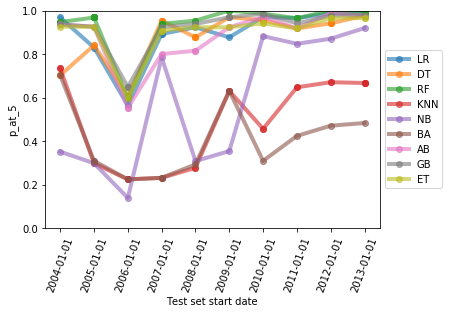

<Figure size 432x288 with 0 Axes>

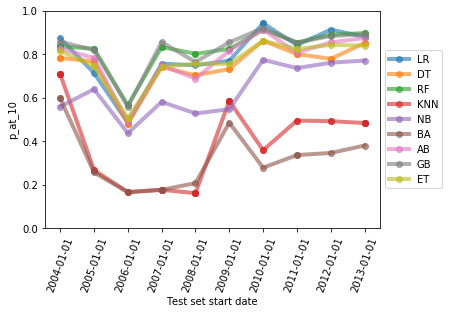

<Figure size 432x288 with 0 Axes>

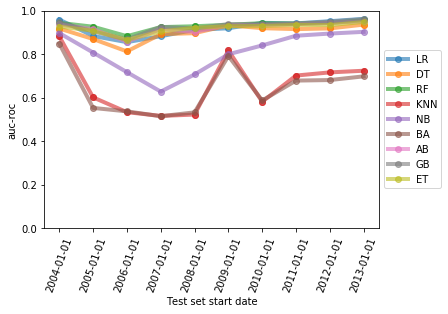

In [21]:
importlib.reload(pipeline)

best_models_per_metric = {}

for metric in metrics_to_display:
    #For each model, find the set of parameters that work the best in each train/test set
    best_models = pipeline.get_best_models_of_each_type_for_each_train_test_set(models_to_run,results,'test_set_start_date', metric)
    pipeline.plot_models_in_time(models_to_run, best_models, metric)
    best_models_per_metric[metric]=best_models
   